## Loding the Data

In [1]:
import seaborn as sns
import pandas as pd
import re
import spacy
import string
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import pickle

In [11]:
df = pd.read_csv("data/city_SanJose_Minutes.csv")

df = df.iloc[:, 1:]

In [53]:
art_df = pd.DataFrame(df.groupby('artID').sum('content')['subID'])

art_df = art_df.loc[art_df.subID>3]

df = df.merge(art_df, on='artID', how = 'inner')

In [56]:
df_subID = df[df['subID_x']!=0]
df_subID = df_subID.reset_index()
df_subID

,index,content,subID_x,mainID,artID,date,hasDollar,hasItem,hasSection,subID_y
0,3,2.1 Approval of City Council Minutes.None prov...,1,2,1,"January 7,2020",False,False,False,45
1,4,2.2 Final Adoption of Ordinances.20-056 Final ...,2,2,1,"January 7,2020",False,False,True,45
2,5,2.3 Approval of Council Committee Minutes.\nNo...,3,2,1,"January 7,2020",False,False,False,45
3,6,2.4 20-005 Mayor and Council Excused Absence R...,4,2,1,"January 7,2020",False,True,False,45
4,7,2.5 City Council Travel Reports.\nNone provided.,5,2,1,"January 7,2020",False,False,False,45
...,...,...,...,...,...,...,...,...,...,...
1201,1637,8.5 20-1646 FY 2019-2020 Consolidated Annual P...,5,8,45,"December 15, 2020",False,True,False,567
1202,1639,9.1 20-1663 Successor Agency to the Redevelopm...,1,9,45,"December 15, 2020",False,True,False,567
1203,1641,10.1 Land Use on Consent Calendar \n (a) 20-...,1,10,45,"December 15, 2020",False,True,False,567
1204,1642,10.2 20-1649 HP19-008 - Appeal Hearing on the ...,2,10,45,"December 15, 2020",False,True,False,567


## Preprocessing

In [57]:
def clean_text(text):
    #text = text.decode("UTF-8")
    text = text.replace('\n'," ")
    text = text.replace('\x0c'," ")
    text = re.sub(r"-", " ", text) # Split the words with "-" (for example：pre-processing ==> pre processing）
    text = re.sub(r"\d+/\d+/\d+", "", text) # Take out the dates
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) # Take out the time
    text = re.sub(r"[\w]+@[\.\w]+", "", text) # Take out the emails
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) # Take out the websites
    pure_text = ''
    # Validate to check if there are any non-text content 
    for letter in text:
        # Keep only letters and spaces
        if letter.isalpha() or letter==' ':
            pure_text += letter
    # Join the words are not stand-alone letters
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return ' '.join(mytokens)

def nltk_stemmer(text):
    porter_stemmer = PorterStemmer()
    word_data = ' '.join(text)
    # First Word tokenization
    nltk_tokens = nltk.word_tokenize(word_data)
    #Next find the roots of the word
    t = []
    for w in nltk_tokens:       
        t.append(porter_stemmer.stem(w))
    return t

In [58]:
text = df_subID['content']

text = text.apply(lambda x: clean_text(x))

text = text.apply(lambda x: spacy_tokenizer(x))

In [215]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.085, stop_words=ENGLISH_STOP_WORDS)

word_matrix = tfidf_vectorizer.fit_transform(text)

vocab = tfidf_vectorizer.get_feature_names()

In [236]:
vocab

['aaa',
 'aae',
 'ab',
 'abate',
 'abatement',
 'abdo',
 'ability',
 'able',
 'abmei',
 'abode',
 'absence',
 'abstain',
 'abuse',
 'academic',
 'academically',
 'accelerate',
 'acceptable',
 'acceptance',
 'access',
 'accessibility',
 'accessible',
 'accessory',
 'accident',
 'accolade',
 'accommodate',
 'accommodation',
 'accomplish',
 'accomplishment',
 'accord',
 'accordance',
 'account',
 'accountability',
 'accountable',
 'accrue',
 'accusation',
 'achieve',
 'acknowledge',
 'acquire',
 'acquisition',
 'acting',
 'actions',
 'activation',
 'active',
 'activist',
 'actuarial',
 'acutite',
 'ad',
 'ada',
 'adams',
 'adapt',
 'adaptable',
 'adaptation',
 'addenda',
 'addende',
 'addendum',
 'addiction',
 'adding',
 'addition',
 'additionally',
 'adequacy',
 'adequate',
 'adequately',
 'adira',
 'adj',
 'adjacent',
 'adjourn',
 'adjournment',
 'adjust',
 'adjustment',
 'adjustments',
 'administer',
 'administrator',
 'adopted',
 'adoption',
 'adu',
 'adult',
 'advance',
 'advanced',


In [332]:
word_matrix.shape

(1206, 1198)

## Select Number of Topics

In [213]:
# Cosine similarity should be higher the better. Let's compare with the maximum cosine similarity(aka topics)'s lowest value.

def min_of_max(low, high):
    min_of_max = []
    for i in range(low, high):
        lda_tfidf = LatentDirichletAllocation(n_components=i, random_state=0)
        lda_tfidf.fit(word_matrix)
        topic_matrix = lda_tfidf.transform(word_matrix)
        topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')
        topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)
        min_of_max.append(topic_matrix_df.iloc[:,:].max(axis=1).min())
    return min_of_max

In [213]:
min_of_max = min_of_max(2,16)

# The good standard seems to be higher than 0.35
sns.lineplot(range(1,15),min_of_max);

In [321]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.0085, max_df=0.9, stop_words=ENGLISH_STOP_WORDS)

word_matrix = tfidf_vectorizer.fit_transform(text)

vocab = tfidf_vectorizer.get_feature_names()

word_matrix.shape

(1206, 1198)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


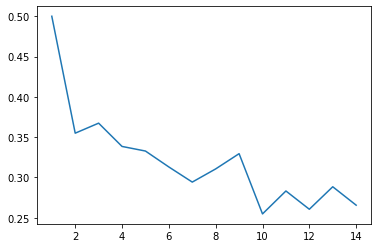

In [322]:
# Cosine similarity should be higher the better. Let's compare with the maximum cosine similarity(aka topics)'s lowest value.

min_of_max = []
for i in range(2,16):
    lda_tfidf = LatentDirichletAllocation(n_components=i, random_state=0)
    lda_tfidf.fit(word_matrix)
    topic_matrix = lda_tfidf.transform(word_matrix)
    topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')
    topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)
    min_of_max.append(topic_matrix_df.iloc[:,:].max(axis=1).min())
    
# The good standard seems to be higher than 0.35
sns.lineplot(range(1,15),min_of_max);

In [324]:
for i in range(len(min_of_max)):
    if min_of_max[i]>0.3:
        print(i+2, min_of_max[i])

2 0.5001397433327931
3 0.3549343391378238
4 0.3673741399082877
5 0.33846795948398906
6 0.33275154423104925
7 0.3129720612839284
9 0.3105618871450793
10 0.3294751943083397


In [338]:
pd.DataFrame(lda_tfidf.components_, columns=vocab) # Word matrix

,aa,absence,absent,accept,acceptance,access,accessory,accommodation,accord,accordance,...,workers,working,workplan,works,world,write,year,youth,zone,zoning
0,1.559074,7.853505,0.379659,0.138229,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
1,0.066667,0.066667,0.066667,0.066667,0.066668,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
2,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.294033,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,2.948713
3,0.066667,0.066667,0.624615,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066669,0.066667,0.066667,0.732421,0.066667,0.066667,0.159568,0.066667,0.066667,0.066667
4,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.690973,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
5,0.066667,12.730929,0.066667,0.340288,0.066749,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
6,0.066667,0.066667,0.066667,0.066668,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
7,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
8,2.379433,0.066669,2.105977,1.479535,0.943863,0.629362,0.312434,0.066667,0.066675,0.066667,...,0.237571,0.159750,0.066667,4.277445,0.853872,0.066667,9.165830,0.066667,1.096271,0.066667
9,2.398709,0.066743,6.166650,14.530835,0.066701,2.194019,0.203220,0.066667,0.066672,1.685357,...,0.066668,0.066700,3.515427,3.234345,0.066668,1.120882,11.770527,0.797233,0.066667,0.066667


In [137]:
def n_topic_df(n):
    lda_tfidf = LatentDirichletAllocation(n_components=n, random_state=0)
    lda_tfidf.fit(word_matrix)
    topic_matrix = lda_tfidf.transform(word_matrix)
    topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')
    topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)
    all_df = pd.concat([df_subID,topic_matrix_df], axis=1)
    return all_df

In [138]:
def n_topic_word(n):
    lda_tfidf = LatentDirichletAllocation(n_components=n, random_state=0)
    lda_tfidf.fit(word_matrix)
    word_topic_matrix_df = pd.DataFrame(lda_tfidf.components_, columns=vocab).T.add_prefix('topic_')
    return word_topic_matrix_df

In [326]:
all_df = n_topic_df(10)

word_topic_matrix_df = n_topic_word(10)

## Word Embedding

In [101]:
import gensim
from gensim import corpora, models, similarities

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [126]:
# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Creating our tokenizer function
def spacy_tokenizer_2(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

In [127]:
clean_list = [clean_text(i) for i in text]

spacy_list =[spacy_tokenizer_2(i) for i in clean_list]

spacy_list

In [128]:
w2v = gensim.models.Word2Vec(spacy_list, size=100, window=5, min_count=1, workers=2, sg=1)

In [129]:
list(w2v.wv.vocab.items())

[('approval', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1d90>),
 ('city', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1520>),
 ('council', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1df0>),
 ('minutesnone', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1490>),
 ('provide', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1430>),
 ('final', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e13a0>),
 ('adoption', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1340>),
 ('ordinance', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e12e0>),
 ('ord', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1580>),
 ('san', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1250>),
 ('jose', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e11c0>),
 ('rezone', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e1160>),
 ('certain', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e13d0>),
 ('real', <gensim.models.keyedvectors.Vocab at 0x7fe6a94e10d0>),
 ('property', <gensim.models.keyedvectors.Vocab at 0x7fe6a94

In [143]:
'sergio' in [i for j in spacy_list for i in j] # Check to see if certain word is in the list

True

## Key Words Search

In [314]:
w2v.wv.most_similar(['covid'] ,topn=10)


[('pandemic', 0.9002338647842407),
 ('spread', 0.832292377948761),
 ('novel', 0.8123106956481934),
 ('response', 0.8114635348320007),
 ('crisis', 0.7792248129844666),
 ('distribution', 0.774034857749939),
 ('food', 0.7724790573120117),
 ('operation', 0.7669748067855835),
 ('sheltering', 0.7606569528579712),
 ('loss', 0.7600347399711609)]

In [316]:
key_word=[]
for i in range(10):
    try:
        key_word.append(w2v.wv.most_similar(['covid'] ,topn=10)[i][0])
    except:
        print("try different words")
key_word

['pandemic',
 'spread',
 'novel',
 'response',
 'crisis',
 'distribution',
 'food',
 'operation',
 'sheltering',
 'loss']

In [327]:
for i in key_word:
    try:
        print(word_topic_matrix_df.loc[i].idxmax())
    except:
        print("no word available")

topic_9
topic_9
no word available
topic_9
topic_9
topic_0
topic_0
topic_9
no word available
topic_9


In [334]:
# See the content by topic

for i in all_df.sort_values('topic_9', ascending = False).head(10).content:
    print(i)
    print('===============================')

8.1 20-1094 Citywide Residential Anti-Displacement Strategy. - Not heard before 5:00 P.M.  

 Recommendation: (a) Accept the staff report and approve the 10 recommendations of the Citywide  

  Residential Anti-Displacement Strategy. 

 (b) Approve workplans for the first three recommendations: 

  (1) Support Equitable COVID-19 Recovery and Impact Mitigation Measures for  

 Renters and Homeowners; 

  (2) Establish a Neighborhood Tenant Preference for Affordable Housing; and 
 
 

 

(Item Continued on the Next Page) 



 
 City Council Draft Minutes/Synopsis September 22, 2020 

 City of San José Page 18 September 22, 2020 

 
8.1 20-1094 Citywide Residential Anti-Displacement Strategy. – (Cont’d). 
 

  (3) Explore a Community Opportunity to Purchase Program/Ordinance. 

 (c) Direct staff to return to the City Council with an update on progress in 12 months. 

 CEQA: Not a Project, File No. PP17-009, Staff Reports, Assessments, Annual Reports,  

 and Informational Memos that invol

In [272]:
# See the content by key words

for i in all_df.sort_values(word_topic_matrix_df.loc['covid'].idxmax(), ascending = False).head(10).content:
    print(i)
    print('===============================')

3.5 20-871 Community and Economic Recovery and Coronavirus Relief Funds for Local  
 Assistance Efforts. 
 

 Recommendation: (a) Accept the verbal staff report on the Emergency Operations Center Community and 

 Economic Recovery efforts. 

 (b) 

  (1) Approve allocating $2,479,500 of the Coronavirus Relief Funds for Resident  

 Assistance to fund a job training and subsidized employment program through  

 work2future, including wrap-around services such as childcare for individuals who have  

 experienced job loss or other impacts related to COVID-19, and  

  (2) Direct the City Manager to conduct additional community outreach regarding the  

 expenditure of the remaining Resident Assistance funding. 

 (c) Adopt a resolution authorizing the City Manager to negotiate and execute the  

 following grant agreements, including any amendments and revisions to said  

 agreements and any necessary documents to effectuate the grant, to use Coronavirus  

 Relief Funds to provide assi

In [328]:
# See the index list

index_list = []
for i in all_df.sort_values(word_topic_matrix_df.loc['covid'].idxmax(), ascending = False).head(20).index:
    index_list.append(i)

index_list

[911,
 405,
 162,
 382,
 767,
 794,
 589,
 572,
 540,
 627,
 677,
 726,
 170,
 951,
 615,
 472,
 522,
 469,
 467,
 403]

In [329]:
# See the dates

for i in index_list:
    print(all_df.iloc[i]['date'])

September 22, 2020
April 28, 2020
February 25, 2020
April 21, 2020
August 11, 2020
August 18, 2020
June 23, 2020
June 16, 2020
June 9, 2020
June 23, 2020
June 30, 2020
June 30, 2020
February 25, 2020
October 6, 2020
June 23, 2020
May 19, 2020
June 9, 2020
May 19, 2020
May 19, 2020
April 28, 2020


In [330]:
for i in index_list:
    print(all_df.iloc[i].content)
    print("==================================================")

8.1 20-1094 Citywide Residential Anti-Displacement Strategy. - Not heard before 5:00 P.M.  

 Recommendation: (a) Accept the staff report and approve the 10 recommendations of the Citywide  

  Residential Anti-Displacement Strategy. 

 (b) Approve workplans for the first three recommendations: 

  (1) Support Equitable COVID-19 Recovery and Impact Mitigation Measures for  

 Renters and Homeowners; 

  (2) Establish a Neighborhood Tenant Preference for Affordable Housing; and 
 
 

 

(Item Continued on the Next Page) 



 
 City Council Draft Minutes/Synopsis September 22, 2020 

 City of San José Page 18 September 22, 2020 

 
8.1 20-1094 Citywide Residential Anti-Displacement Strategy. – (Cont’d). 
 

  (3) Explore a Community Opportunity to Purchase Program/Ordinance. 

 (c) Direct staff to return to the City Council with an update on progress in 12 months. 

 CEQA: Not a Project, File No. PP17-009, Staff Reports, Assessments, Annual Reports,  

 and Informational Memos that invol